<h1 style='text-align:center'>User Behavior and A/A/B Test Analysis Project </h1>

## Project Description / Business Problem

> You work at a startup that sells food products. You need to investigate user behavior for the company's app.
First study the sales funnel. Find out how users reach the purchase stage. 

>Then look at the results of an A/A/B test. The designers would like to change the fonts for the entire app, but the managers are afraid the users might find the new design intimidating. They decide to make a decision based on the results of an A/A/B test.
The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. Find out which set of fonts produces better results.
You'll be using the same dataset for general analytics and for A/A/B analysis. In real projects, experiments are constantly being conducted. Analysts study the quality of an app using general data, without paying attention to whether users are participating in experiments.

# Findings 
1. A further analysis should be done looking at potential errors occurring during the mainscreen and offerscreen stages based on the differing proportions amongst the control groups.
2. Need for improvements in retention at the offer screen as well as potential for improvement in getting customer's from purchasing the items that they have in their cart.
3. Based on the non-significant the A/B test results, stabilizing cumulative charts, the company should: Stop the experiment as the results don't show any improvement in  user conversion rates between the control groups and the experimental group
    - all relevant t-tests regardless of outlier presence: p > .05

# Datasets Used

Each log entry is a user action or an event.
 - EventName — event name
 - DeviceIDHash — unique user identifier
 - EventTimestamp — event time
 - ExpId — experiment number: 246 and 247 are the control groups, 248 is the test group

# Packages Used

In [281]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
from datetime import datetime
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import graph_objects as go
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from matplotlib import ticker
from datetime import datetime, timedelta
%matplotlib inline

# General Overview

In [282]:
df = pd.read_csv(r"C:\Users\garci\Downloads\logs_exp_us.csv",sep='\t')


In [283]:
#changing column names for convenience
df.columns = ['event_name', 'user_id', 'timestamp', 'experiment_id']

First things first, we'll check for any instance of a null values, duplicates, and do the necessary data wrangling thereafter for any other oddities in the data.

## Event timestamps -- Potential error

Note: went back to do this after finding that the date in place did not follow a sequential order when taking the minimum event for each event per user. The minimum timestamps for some users did not follow a logical user journey cycle (visit the main screen -> payment screen). 

The most probable reason is that we received data starting from some point of time - so, if this time point was the middle of some user's session, his/her first event would be unpredictable. It makes sense too because a user can have the cart or payment screen saved and then accessed it back again (thus avoiding the main screen).

In [284]:
# current row value - previous row
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

User_Mindate_event = df.pivot_table(index='user_id',
                                    columns='event_name',
                                    values='timestamp',
                                    aggfunc='min')

# referencing the previous row values with .shift() -> (x - x.shift())
User_Mindate_event[[
    'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
    'PaymentScreenSuccessful', 'Tutorial'
]].iloc[:, :-1].apply(lambda x: x - x.shift(+1), 1)

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,NaT,NaT,NaT
6909561520679493,NaT,0 days 00:00:10,-1 days +23:59:54,00:00:00
6922444491712477,NaT,0 days 00:00:13,-1 days +23:59:54,00:00:00
7435777799948366,NaT,NaT,NaT,NaT
7702139951469979,NaT,0 days 00:00:02,1 days 09:58:49,00:00:00
...,...,...,...,...
9217594193087726423,NaT,NaT,-1 days +23:59:50,-1 days +23:59:59
9219463515465815368,NaT,1 days 11:22:31,0 days 00:00:43,00:02:36
9220879493065341500,NaT,4 days 03:29:02,0 days 00:00:16,NaT


## Normal checks

In [285]:
#null check
df.isnull().sum()

event_name       0
user_id          0
timestamp        0
experiment_id    0
dtype: int64

In [286]:
def missing_values(data):
    """
    Function that takes in a dataframe, iterates over each of its columns and checks for
    common indicators of missing values (ie. negative values).   

    Args:
         data (pandas.DataFrame): Dataframe to be checked

    Returns:
        list (dict): a list containing (if any) a dictionar[y/ies] of key:value pair in the 
        following format - {column's missing value: % of column's missing value} - sorted in descending order
    """
    
    miss = {}
    if len(data.columns) <= 0:
        print('Something went wrong. No columns detected.')
    for i in data.columns:  # iterate through all columns in dataset to search for each defined missing value
        if data[i].isnull().any():
            miss[i] = 'Null values ' + str(
                round(
                    len(data[data[i].isnull() == True]) / len(data) * 100, 2))
        if len(data[data[i] == 0]) > 1:
            miss[i] = 'Zero values ' + str(
                round(len(data[data[i] == 0]) / len(data) * 100, 2))
        try:
            if len(np.where(data[i] == '')) > 1:
                miss[i] = 'Empty strings ' + str(
                    round(len(data[data[i] == '']) / len(data) * 100, 2))
        except:
            pass
        if np.issubdtype(data[i].dtype,
                         np.number) and len(data[data[i] < 0]) > 1:
            miss[i] = 'Negative values ' + str(
                round(len(data[data[i] < 0]) / len(data) * 100, 2))
        try:
            if len(data[data[i].str.lower.isin(['n/a', 'na', 'an', 'n\a', '?'
                                                ])]) > 1:
                miss[i] = 'other null values present'
        except:
            try:
                if len(data[data[i].isin(['N/A', '?', 'na', 'Na', 'N/a'
                                          ])]) > 1:
                    miss[i] = 'other null values present'
            except:
                print(i)
                continue
    return sorted(miss.items(),
                  key=lambda x: float(miss[x[0]].split(' ')[-1]),
                  reverse=True)

In [287]:
missing_values(df)

timestamp


C:\Users\garci\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



[]

No instances of null values! Next up, duplicates. (Note: timestamp was printed bc it ran into a exception. From the looks of it, it was the value comparison--date to string--that threw it off, will update accordingly later).

In [288]:
#checking for duplicates
df[df.duplicated(keep=False)]

,event_name,user_id,timestamp,experiment_id
452,MainScreenAppear,5613408041324010552,2019-07-30 01:19:44,248
453,MainScreenAppear,5613408041324010552,2019-07-30 01:19:44,248
2348,CartScreenAppear,1694940645335807244,2019-07-31 14:51:39,248
2350,CartScreenAppear,1694940645335807244,2019-07-31 14:51:39,248
3572,MainScreenAppear,434103746454591587,2019-07-31 19:59:37,248
...,...,...,...,...
242359,PaymentScreenSuccessful,2382591782303281935,2019-08-07 12:27:29,246
242360,PaymentScreenSuccessful,2382591782303281935,2019-08-07 12:27:29,246
242362,CartScreenAppear,2382591782303281935,2019-08-07 12:27:29,246
242634,MainScreenAppear,4097782667445790512,2019-08-07 12:36:58,246


In [289]:
len(df[df.duplicated(keep=False)]) - len(df[df.duplicated(
    keep='first')]), (len(df[df.duplicated(keep=False)]) -
                      len(df[df.duplicated(keep='first')])) / len(df) * 100

(355, 0.1454167110426583)

When checking duplicate rows, we can observe that there are 355 (0.15%) rows that have been marked as duplicates. Based on the variables, it makes sense to drop them given the unlikelihood of them appearing, especially at the same time; we'll keep the first instance of rows marked as duplicate. Lastly, we'll mark this down and let the applicable person regarding the duplicate instance.

In [290]:
df = df[~df.duplicated()].reset_index(drop=True)

How many events are in the logs? 

In [291]:
def custom_graph(grid_axis, labelsize, xlabel, ylabel, title, fontsize, pad, grid=True):
    """
    Function that takes in graph variables for the purpose of customizing 
    their default settings (ie. setting label size)

    Args:
        labelsize, fontsize,pad (int,float)
        grid_axis,xlabel,ylabel,title (str) 

    Returns:
        None: displays plot with modified chart settings 
    """
    sns.despine()
    if grid == True:
        ax.grid(axis=grid_axis, linewidth=.5, zorder=2)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('lightgrey')
    ax.tick_params(labelsize=labelsize)
    ax.tick_params(axis='both', left=False, bottom=False)
    
    # labels
    plt.ylabel(ylabel, labelpad=15, fontsize=16)
    plt.xlabel(xlabel, labelpad=15, fontsize=16)
    plt.title(title, fontsize=fontsize, pad=pad)
    plt.show()

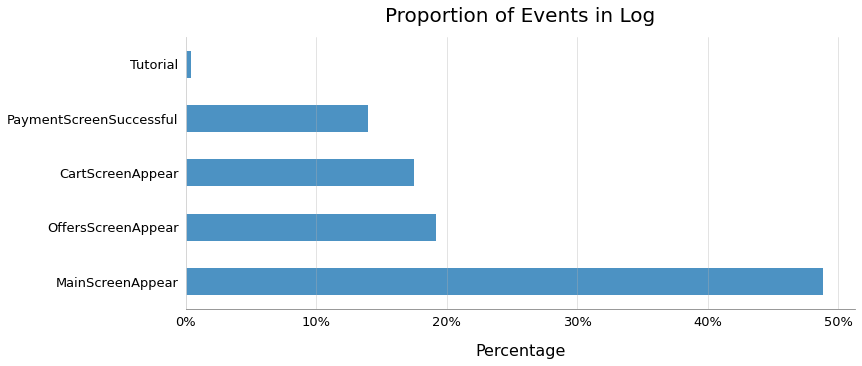

In [292]:
fig, ax = plt.subplots(figsize=(12, 5))
df['event_name'].value_counts(normalize=True).plot(kind='barh',
                                                   rot=0,
                                                   alpha=.8)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1, decimals=0))
plt.grid(axis='x', alpha=.7)
custom_graph('x', 13, 'Percentage', '', 'Proportion of Events in Log', 20, 15)

There are a total of four events; all follow a sequential pattern with the exception of tutorial. 

How many users are in the logs?

In [293]:
print(
    'Unique Users:', df['user_id'].nunique(), '\n', 'Total Events',
    len(df['user_id']), '\n', 'Top User:',
    round(
        df['user_id'].value_counts(normalize=True).sort_values().tail(1) * 100,
        3).values[0], '%')

Unique Users: 7551 
 Total Events 243713 
 Top User: 0.947 %


There are a total of 7,551 users and a total of 243,713 events recorded by them. The top user made close to 1% of the events recorded in the log. Considering the number of events in the log, this will be explored further.

In [294]:
#group by users and obtain their total event count (here event_name is a dummy variable)
eventUser_count = df.groupby('user_id').agg({'event_name':
                                             'count'})['event_name']

In [295]:
events_mean = eventUser_count.mean()
events_mean

32.27559263673685

On average, a user would go through 32 events.

Visualizing the distribution of events per user

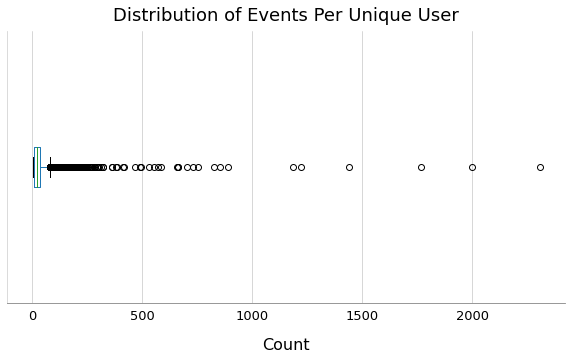

In [296]:
ax = eventUser_count.sort_values().plot.box(figsize=(10, 5), vert=False)

ax.set_yticklabels([])
custom_graph('x', 13, 'Count', '', 'Distribution of Events Per Unique User', 18, 10)

The average is not the correct measurement to use and we will report the median number of events per user instead. Per the box plot, some users had > 2000 events recorded for them. This high interaction with the platform may pose an issue with the planned hypothesis test. 

In [297]:
#general statistical description of events per user
print(eventUser_count.describe())
print()
print('95 quantile:', eventUser_count.quantile(.95), '\n', '99 quantile:',
      eventUser_count.quantile(.99))

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

95 quantile: 89.0 
 99 quantile: 200.5


Let's check out the time range.

In [298]:
df['timestamp'].max() -df['timestamp'].min()

Timedelta('13 days 16:31:41')

Over 2,300 event logs were recorded for just one user within a time span of roughly 14 days.

In [299]:
days, hour, max_Usersession = 14,24,eventUser_count.max()
(max_Usersession/days)/hour

6.866071428571428

So around 6 events per hour. This sounds abnormal given that the company sells food. CLearly we have outliers to take care of. We'll need to check out on the date before doing so to get a better picture of this.


Let's plot a histogram to look at the distribution of date and time.

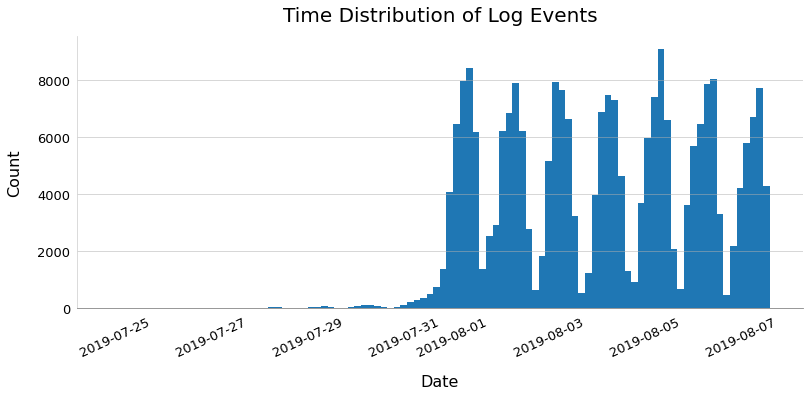

In [300]:
ax = df['timestamp'].hist(figsize=(13, 5), bins=100)
plt.grid(axis='x')
ax.tick_params('x', labelrotation=25)
custom_graph('y', 13, 'Date', 'Count', 'Time Distribution of Log Events', 20,15)

The data seems to be unequally distributed for the period. Older events could have ended up in some user's log due to technical reasons and as such, will also be listed down in the email sent to our "hypothetical" collegaue.

Given the share of where the count seems to be roughly located at (between June 31st to July 7th), we'll use a timespan of exactly 7 days. So in this case, the start of the week will be 7 days from the max recorded time.

In [301]:
start_of_week = str(df['timestamp'].max() - timedelta(days=7))
start_of_week

'2019-07-31 14:15:17'

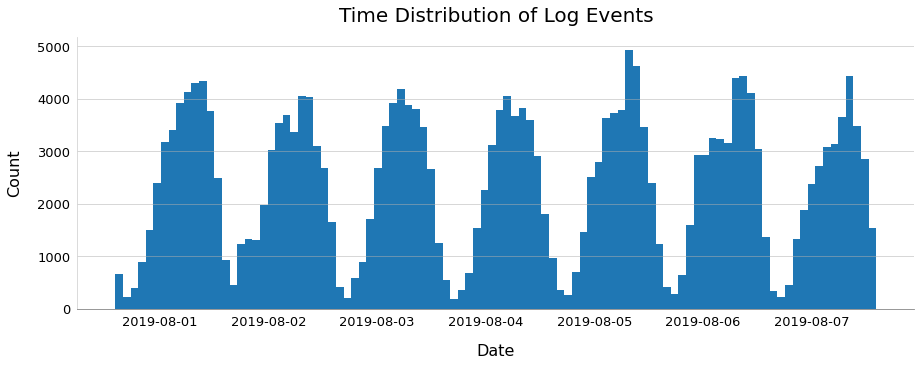

In [302]:
ax = df[df['timestamp'] > start_of_week]['timestamp'].hist(figsize=(15, 5),
                                                           bins=100)
plt.grid(False)
custom_graph('y', 13, 'Date', 'Count', 'Time Distribution of Log Events', 20,15)

Cutting off the old events, the distribution of time now looks distributed. 

In [303]:
new = df[(df['timestamp'] > start_of_week)]

(len(df) - len(new) )/ len(df) * 100, len(
    df[(df['timestamp'] < start_of_week)])

(0.8436152359537654, 2056)

Only 2,056 or .84% of event instances will be dropped--not a lot of data. We'll save the dataframe into a new variable: data.

In [304]:
data = new.reset_index(drop=True).copy()
data.head()

,event_name,user_id,timestamp,experiment_id
0,MainScreenAppear,384642128335787102,2019-07-31 14:15:35,246
1,MainScreenAppear,5924591427413218387,2019-07-31 14:15:42,247
2,PaymentScreenSuccessful,3001657979204168225,2019-07-31 14:15:57,248
3,CartScreenAppear,3001657979204168225,2019-07-31 14:15:57,248
4,MainScreenAppear,3773293147331066460,2019-07-31 14:16:01,248


In [305]:
#sanity check
print(data.isnull().sum().sum())
len(data), len(df), round(len(data) / len(df) * 100, 2)

0


(241657, 243713, 99.16)

Now, based on the graph, let's check out the distribution again. We expect it to have shorten.


In [306]:
#group by users and obtain their total event count (here event_name is a dummy variable)
eventUser_count_ = data.groupby('user_id').agg({'event_name':
                                             'count'})['event_name']

In [307]:
days =7

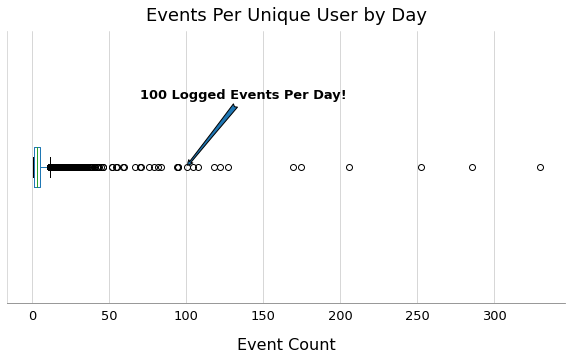

In [308]:
ax = eventUser_count.apply(lambda x: (x/days)).plot.box(figsize=(10, 5), vert=False)
plt.annotate("100 Logged Events Per Day!",
             xy=(100, 1),
             xytext=(70, 1.25),
             fontweight='bold',
             fontsize=13,
             arrowprops=dict(arrowstyle="fancy"))
ax.set_yticklabels([])
custom_graph('x', 13, 'Event Count', '', 'Events Per Unique User by Day', 18, 10)

Interestingly enough, unique users still logged an erroneous amount of events per day, some over 100 per day. So given the chart and known quantiles (95%-89, 99%-200), we'll be more conservative and filter at the 95.8% of user. This % was chosen given the median (20) which is on the extreme start of the graph.

In [309]:
eventUser_count_.quantile(.998) / (7 * 24), eventUser_count_.quantile(.998)

(3.4750952380952747, 583.8160000000062)

In [310]:
user_Over580_sessions = list(
    eventUser_count_[eventUser_count_ > eventUser_count_.quantile(.998)].index)
user_Over580_sessions

[197027893265565660,
 1055544042902443290,
 1100007125648169445,
 1754140665440434215,
 1989685320445148348,
 2305766456715991733,
 3337471580007169353,
 3521696259961091617,
 3610536745613892312,
 4623191541214045580,
 4713748699910253089,
 5996739817823449506,
 6304868067479728361,
 6932517045703054087,
 7738058666231999878,
 8118046800480174342]

In [311]:
Users_Over580_sessions = data.query("user_id in @user_Over580_sessions")
Useroutlier_index = list(Users_Over580_sessions['user_id'].unique())

(len(Users_Over580_sessions) /
 len(data)) * 100, Users_Over580_sessions['user_id'].nunique(), len(data)

(7.130354179684428, 16, 241657)

16 users were responsible for 7% of the 241k recorded log events. This may impact the results later and therefore will be useful in the hypothesis test. This information will also be shared with a "hypothetical" collegaue in a later email.


Withholding outliers and using the median, a typical user will have a total of 16 recorded log events in a given week.

## Datetime type conversions

Based on the time, we'll create new columns containing: day, hour, and day hour only.

In [312]:
#day and hour of interest givent the 7 day timespan
data['day'] = data['timestamp'].dt.date
data['hour'] = data['timestamp'].dt.hour
data['day_hour'] = pd.to_datetime(data['day']) + pd.to_timedelta(data.hour,
                                                                 unit='h')

Users_Over580_sessions['day'] = Users_Over580_sessions['timestamp'].dt.date
Users_Over580_sessions['hour'] = Users_Over580_sessions['timestamp'].dt.hour
Users_Over580_sessions['day_hour'] = pd.to_datetime(
    Users_Over580_sessions['day']) + pd.to_timedelta(
        Users_Over580_sessions.hour, unit='h')

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\garci\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [313]:
print(data[['day','hour','day_hour']].head())
print()
print(Users_Over580_sessions[['day','hour','day_hour']].head())

          day  hour            day_hour
0  2019-07-31    14 2019-07-31 14:00:00
1  2019-07-31    14 2019-07-31 14:00:00
2  2019-07-31    14 2019-07-31 14:00:00
3  2019-07-31    14 2019-07-31 14:00:00
4  2019-07-31    14 2019-07-31 14:00:00

             day  hour            day_hour
1573  2019-07-31    20 2019-07-31 20:00:00
1574  2019-07-31    20 2019-07-31 20:00:00
1592  2019-07-31    20 2019-07-31 20:00:00
2442  2019-07-31    21 2019-07-31 21:00:00
2451  2019-07-31    21 2019-07-31 21:00:00


## Unique Users
Making sure unique users are placed into ONE experimental group.

In [314]:
#unique user id
unique_users = data.groupby(['user_id'])

#users and their unique experiment(s)
users_group = unique_users.apply(lambda x: x['experiment_id'].unique())

#if user contains more than one experimental group print it out
users_group[users_group.apply(lambda x: len(x)) > 1]

Series([], dtype: object)

Nice, all users were placed into one experimental group.

Lastly, we'll check for the unique users per experimental group to ensure that the share is roughly the same across the experimental groups.

In [315]:
proportion_experiment = data.groupby(['experiment_id']).agg({
    'user_id':
    'nunique'
}).divide(
    data['user_id'].nunique()) 

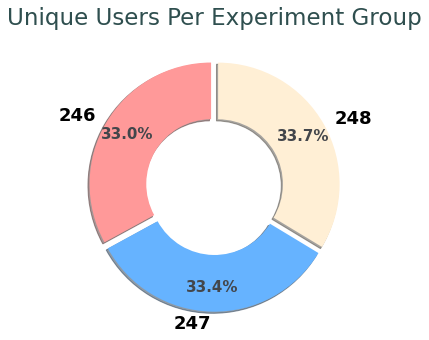

In [316]:
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(aspect="equal"))

explode = (0.05, 0.05, 0.05)
patches, texts, autotexts = plt.pie(
    proportion_experiment['user_id'],
    shadow=True,
    colors=['#ff9999', '#66b3ff', 'papayawhip'],
    labels=proportion_experiment.index,
    autopct='%1.1f%%',
    textprops={
        'fontsize': 18,
        'fontweight': 'bold'
    },
    wedgeprops=dict(width=0.7),
    explode=explode,
    startangle=90,
    pctdistance=0.80,
    radius=1.5)

for text in autotexts:
    text.set_fontsize(15)
    text.set_color('#43464b')
plt.title("Unique Users Per Experiment Group",
          pad=60,
          size=23,
          x=.5,
          color='darkslategray',
          fontname='sans-serif')
plt.tight_layout()
plt.show()

Share of unique users per experimental group are evenly distributed.

In [317]:
data.groupby(['experiment_id']).agg({
        'user_id': 'nunique'
    }).apply(lambda x: x/x.sum())

,user_id
experiment_id,
246,0.329530
247,0.333908
248,0.336561


Share of unique users per experimental group are within 1% and as such, we can safely call them  evenly distributed. 

In [318]:
data.query("user_id not in @Useroutlier_index").groupby(['experiment_id']).agg(
    {
        'user_id': 'nunique'
    }).apply(lambda x: x / x.sum())

,user_id
experiment_id,
246,0.329567
247,0.334220
248,0.336214


Withholding outliers, range amongst the three experimental groups remain within 1% from each other.

# Sales Funnel

Discover potential areas of improvement in terms of conversion rates (key metric in this project).

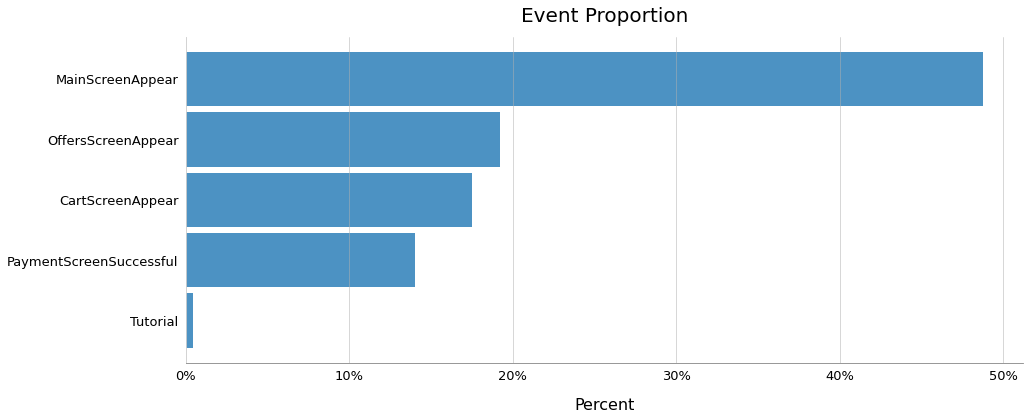

In [319]:
ax = (data['event_name'].value_counts(normalize=True).sort_values().plot.barh(
    legend=False, stacked=True, width=.9, figsize=(15, 6), alpha=.8))

ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
custom_graph('x', 13, 'Percent', '', "Event Proportion", 20, 15)

plt.show()
# worth it

Starting of with the share of event types, we can see that in descending order, they follow a logical path (from main scree to payment screen). However, the tutorial event here seems out of place as it's not as trumped by the payment success screen--indicating an out of place event.


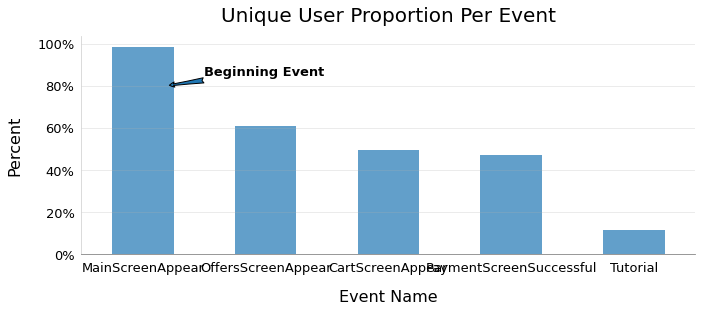

In [320]:
ax = data.groupby(['event_name']).agg({
    'user_id': 'nunique'
}).sort_values('user_id', ascending=False).div(
    data['user_id'].nunique()).plot.bar(rot=0, figsize=(11, 4), legend=False,alpha=.7)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.annotate("Beginning Event",
             xy=(.2, .8),
             xytext=(.5, .85),
             fontweight='bold',
             fontsize=13,
             arrowprops=dict(arrowstyle="fancy"))
plt.grid(axis='y', alpha=.3)
custom_graph('y', 13, 'Event Name', 'Percent',
             'Unique User Proportion Per Event', 20, 15,grid=False)

Around 98% of unique users began the first event while roughly 11% went through the tutorial event. In reflecting about the goal of this project, we'll drop tutorial events as it doesn't seem to be related to the current sales funnel; share of tutorial should have been vastly greater given that it's often one of the first event, not the last, a user would interact with. We'll also be dropping users who don't have a recorded event in the first stage ("MainScreenAppear") since they probably came from the past dates that we dropped earlier.

The sales funnel will be the following: (1) Main screen appears (2) offer screen appears (3)cart screen appears (4) payment screen success.

In [321]:
current_len = len(data)
data = data.query("event_name != 'Tutorial'").reset_index(drop=True)
print('Dropped:', current_len - len(data), '\n', '% Kept:',
      len(data) / current_len*100)
data['event_name'].value_counts()

Dropped: 1009 
 % Kept: 99.58246605726298


MainScreenAppear           117853
OffersScreenAppear          46514
CartScreenAppear            42336
PaymentScreenSuccessful     33945
Name: event_name, dtype: int64

In [322]:
#dropping from outlier dataset as well
current_len = len(Users_Over580_sessions)

Users_Over580_sessions = Users_Over580_sessions.query(
    "event_name != 'Tutorial'").reset_index(drop=True)
print('Dropped:', current_len - len(Users_Over580_sessions), '\n', '% Kept:',
      len(Users_Over580_sessions) / current_len * 100)
Users_Over580_sessions['event_name'].value_counts()

Dropped: 3 
 % Kept: 99.98258951889038


CartScreenAppear           7651
PaymentScreenSuccessful    7200
OffersScreenAppear         1528
MainScreenAppear            849
Name: event_name, dtype: int64

The data DF here was the only one containing rows with tutorial events (1,009 total)--relatively small % dropped: .99%. 

What's interesting to see is that unique users who had more than 580 sessions for the week, overwhelmingly have events logged in the cart and payment screen. Logically, per the previous chart, this doesn't make sense. Another possible explanation could be that the users in the data come from dates that were filtered out previously. This will be also be added to the report as it seems like a technical issues.

In [323]:
Users_Over580_sessions['event_name'].value_counts(normalize=True)

CartScreenAppear           0.444103
PaymentScreenSuccessful    0.417924
OffersScreenAppear         0.088693
MainScreenAppear           0.049280
Name: event_name, dtype: float64

Now for the last cleaning step.

In [324]:
user_Withfirst_event = list(
    data.query("event_name == 'MainScreenAppear'")['user_id'].unique())

print('\t\t\tShare of rows to be dropped:')
print('Unclean DF')
print(
    len(data.query("user_id not in @user_Withfirst_event")['experiment_id']) /
    len(data) * 100)

			Share of rows to be dropped:
Unclean DF
1.0833250224394135


The % printed make sense as per the graph; most of the users had at least one recorded event in the first stage (>98.8%). We'll go ahead and drop those who didn't.

In [325]:
data = data.query("user_id in @user_Withfirst_event")

In [326]:
print(
    data.groupby('experiment_id').agg({
        'user_id': 'nunique'
    }).divide(data['user_id'].nunique()))

                user_id
experiment_id          
246            0.330055
247            0.333962
248            0.335983


Unique users for both DF are evenly distributed amongst the experimental groups.

# Sales Funnel Conversion Rate

Next, we'll use an event funnel to find the conversion rate relative to the previous stage.

### Note: noticed a potential error with time stamp

In [327]:
#for each user, find the time of the first occurrence of each event.
users = data.pivot_table(index='user_id',
                         columns='event_name',
                         values='timestamp',
                         aggfunc='min')

#change order to follow the defined customer journey
users = users[[
    'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
    'PaymentScreenSuccessful'
]]
users.head()

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,2019-08-06 07:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 11:52:54,2019-08-06 11:53:04,2019-08-06 11:52:58,2019-08-06 11:52:58
6922444491712477,2019-08-04 07:19:33,2019-08-04 07:19:46,2019-08-04 07:19:40,2019-08-04 07:19:40
7435777799948366,2019-08-05 01:06:34,NaT,NaT,NaT
7702139951469979,2019-07-31 21:29:54,2019-07-31 21:29:56,2019-08-02 07:28:45,2019-08-02 07:28:45


The columns contain the time each of the events first occurred. If the event didn't take place, its cell value is NaT.
Now, notice for the second user that main screen appears before the offers screen whilst for the next user it doesn't (<b>see 2nd row</b>). Clearly, this may be an issue. (note, I went back and filtered out users who appeared before the 7 day cutoff and still got similar results). 

In [328]:
#for each user, find the time of the first occurrence of each event.
users_ = data.query("user_id not in @Useroutlier_index").pivot_table(index='user_id',
                         columns='event_name',
                         values='timestamp',
                         aggfunc='min')

#change order to follow the defined customer journey
users_ = users[[
    'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
    'PaymentScreenSuccessful'
]]
users.head()

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,2019-08-06 07:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 11:52:54,2019-08-06 11:53:04,2019-08-06 11:52:58,2019-08-06 11:52:58
6922444491712477,2019-08-04 07:19:33,2019-08-04 07:19:46,2019-08-04 07:19:40,2019-08-04 07:19:40
7435777799948366,2019-08-05 01:06:34,NaT,NaT,NaT
7702139951469979,2019-07-31 21:29:54,2019-07-31 21:29:56,2019-08-02 07:28:45,2019-08-02 07:28:45


Even after taking into account the outliers (of which events were centered in the later stages), the problem still holds (<b>see 2nd row</b>).

Time difference in relation to the previous ow should all be positive. Let's check out which users (ourliers and non-outliers) do not follow a sequential order.

In [329]:
#get time difference (days in specific) if any row contains a (-) day then mark that row as false
mask_timestamps = users.apply(
    lambda x: False if any((x - x.shift()).dt.days < 0) else True, 1)

#apply the mask to retrieve those with events that follow a sequential order 
#and then calculate the time differences again
users_Normaltimestamps = users[mask_timestamps].apply(lambda x: x - x.shift(),
                                                      1)
users_Normaltimestamps

event_name,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful
user_id,,,,
6888746892508752,NaT,NaT,NaT,NaT
7435777799948366,NaT,NaT,NaT,NaT
7702139951469979,NaT,0 days 00:00:02,1 days 09:58:49,00:00:00
8740973466195562,NaT,0 days 00:27:11,NaT,NaT
9841258664663090,NaT,0 days 00:01:43,0 days 00:02:33,07:05:12
...,...,...,...,...
9216094175241772920,NaT,NaT,NaT,NaT
9219463515465815368,NaT,1 days 11:22:31,0 days 00:00:43,00:02:36
9220879493065341500,NaT,0 days 00:00:12,0 days 00:00:16,NaT


In [330]:
len(users_Normaltimestamps) / len(
    users), users.reset_index()['user_id'].nunique(
    ) - users_Normaltimestamps.reset_index()['user_id'].nunique()

(0.7108985585342853, 2146)

So 2,146 users (~30%) have minimum dates that don't follow the sequential order of the journey map defined earlier. There are potentially many reasons for this but without knowing the context of the company it's hard to pinpoint the cause of this. Regardless, the users identified will also be included in a "hypothetical" email.

So considering that users don't act linearly as well as the possibility of users to start in different sites (maybe an ad took user directly to offerscreen), then this is quite a complex task. I also noticed that some users had two events recorded had no time differences (ie. event was logged in at the exact second for two events-> see last column in row 3 of dataframe above for an example).

Given this, ordering by the defined user journey map (mainscreen to payment), we'll rely on using the aggregate unique users per event to calculate their relative proportions to each other.

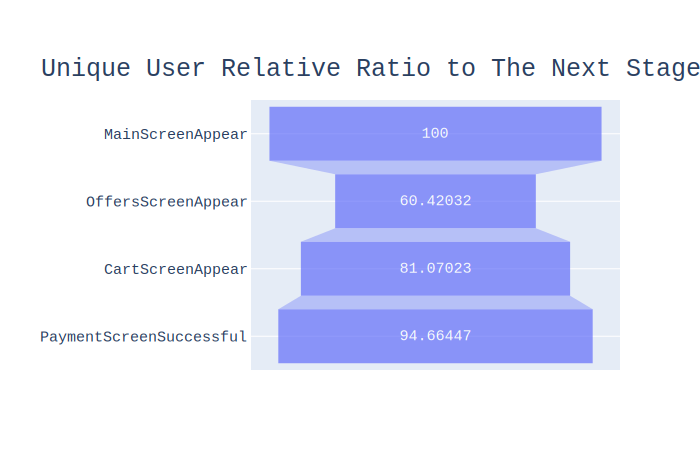

In [331]:
#total unique users per event (value count for each user)
user_funnel = data.groupby('event_name').agg({"user_id":'nunique'}).sort_values('user_id',ascending=False).reset_index()
user_funnel.columns = ['event_name', 'total_count']

#share of users at current stage relative to previous stage
user_funnel['user_conversion'] = user_funnel['total_count'].div(
    user_funnel['total_count'].shift(1)).fillna(1) * 100

fig = go.Figure()

fig.add_trace(go.Funnel(
                x=user_funnel['user_conversion'],
                y=user_funnel['event_name'],
                opacity=.7
))
fig.update_layout(title={
    'text': 'Unique User Relative Ratio to The Next Stage',
    'font': dict(family="Courier New, monospace", size=25), "x":1,"y":.87
},
                  xaxis_title="",
                  yaxis_title="",
                  font=dict(
                      family="Courier New, monospace",
                      size=15,
                  ))

fig.show("svg")

On the aggregate level, roughly 40% of unique users who enter the main screen don't proceed to the next stage, offer screen. However, around 81% of users in the offer screen continue to the next stage screen and 94% of them go on to successfully make their purchase. Let's continue exploring.

In [332]:
user_funnel['total_count'].divide(user_funnel['total_count'].max())*100

0    100.000000
1     60.420315
2     48.982891
3     46.369392
Name: total_count, dtype: float64

In [333]:
total_Uniqueusers = data['user_id'].nunique()
total_Uniqueusers

7423

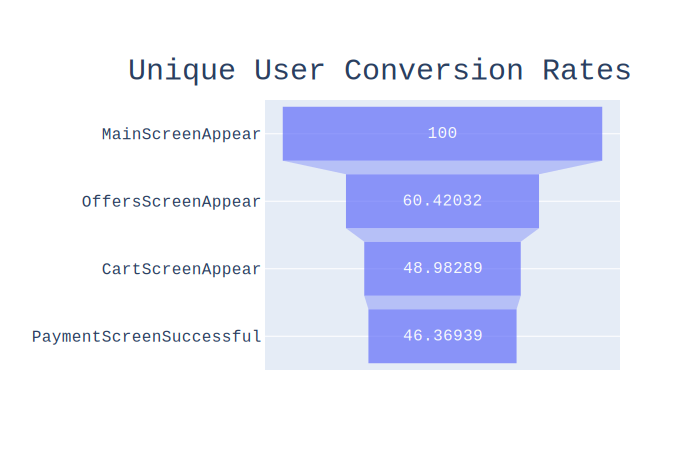

In [334]:
Uniqueuser_event = data.groupby('event_name').agg({'user_id':'nunique'}).sort_values('user_id',ascending=False).divide(total_Uniqueusers)*100

fig = go.Figure()
fig.add_trace(go.Funnel(
                y=Uniqueuser_event.index,
                x=Uniqueuser_event['user_id'].apply(lambda x: x),
                opacity=.7
))
fig.update_layout(title={'text':'Unique User Conversion Rates','font':dict(family="Courier New, monospace"
                                                                           ,size=30), "x":.9,"y":.87},
                  xaxis_title="",
                  yaxis_title="",
                  font=dict(
                      family="Courier New, monospace",
                      size=16
                  ))

fig.show("svg")

Interestingly enough, 48 and then 46% of unique users made it to the critical stages in the funnel (cart and payment screen). It seems like the company has some loyal customers.

In [335]:
data.query("event_name == 'PaymentScreenSuccessful'")['event_name'].value_counts().divide(len(data))*100

PaymentScreenSuccessful    13.946337
Name: event_name, dtype: float64

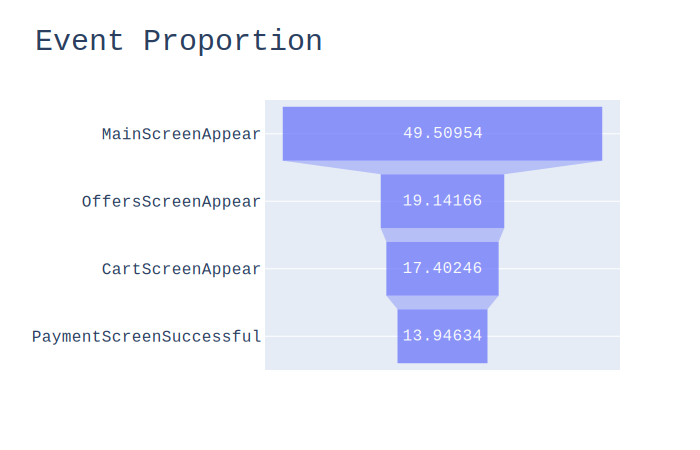

In [336]:
visit_conversion = (data['event_name'].value_counts(normalize=True)*100).reset_index()

fig = go.Figure()
fig.add_trace(go.Funnel(
                x=visit_conversion['event_name'],
                y=visit_conversion['index'].apply(lambda x: x),
                opacity=.7
))
fig.update_layout(title={'text': 'Event Proportion', 'font': dict(family="Courier New, monospace", size=30)},
                  xaxis_title="",
                  yaxis_title="",
                  font=dict(
                      family="Courier New, monospace",
                      size=16
))
fig.show("svg")

Around half of all visits land on the main screen page with < 14% landing on the paymentscreen page.  With a 14% conversion rate 

# Experiment Analysis

How many users are there in each group?


In [337]:
experiment_Uniqueuser_Count = data.groupby(['experiment_id']).agg({'user_id':'nunique'}).reset_index()

In [338]:
round(experiment_Uniqueuser_Count['user_id']/experiment_Uniqueuser_Count['user_id'].sum()*100,3)

0    33.006
1    33.396
2    33.598
Name: user_id, dtype: float64

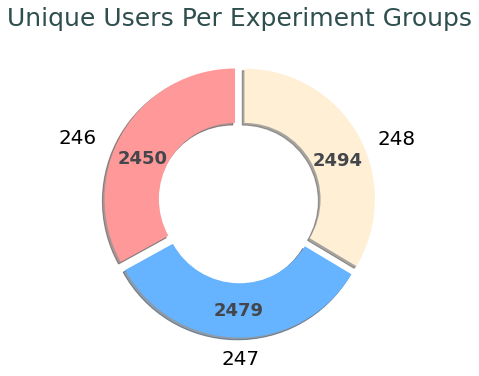

In [339]:
fig, ax = plt.subplots(figsize=(6, 5), subplot_kw=dict(aspect="equal"))

explode = (0.05, 0.05, 0.05)
patches, texts = plt.pie(experiment_Uniqueuser_Count['user_id'].values,
                         shadow=True,
                         colors=['#ff9999', '#66b3ff', 'papayawhip'],
                         labels=experiment_Uniqueuser_Count['user_id'],
                         textprops={
                             'fontsize': 18,
                             'fontweight': 'bold',
                             'color': '#43464b'
                         },
                         labeldistance=.6,
                         wedgeprops=dict(width=0.5),
                         explode=explode,
                         startangle=90,
                         radius=1.2)
texts[1].set_horizontalalignment('center')
texts[1].set_y(-1)

plt.text(texts[0].get_position()[0] - 1,
         texts[0].get_position()[1] + .14,
         experiment_Uniqueuser_Count['experiment_id'][0],
         fontsize=20)
plt.text(texts[1].get_position()[0] - .15,
         texts[1].get_position()[1] - .5,
         experiment_Uniqueuser_Count['experiment_id'][1],
         fontsize=20)
plt.text(texts[2].get_position()[0] + .6,
         texts[2].get_position()[1] + .15,
         experiment_Uniqueuser_Count['experiment_id'][2],
         fontsize=20)
plt.title("Unique Users Per Experiment Groups",
          pad=40,
          size=25,
          x=.5,
          color='darkslategray',
          fontname='sans-serif')
plt.show()

Unique users per experimental groups are roughly evenly distributed. 

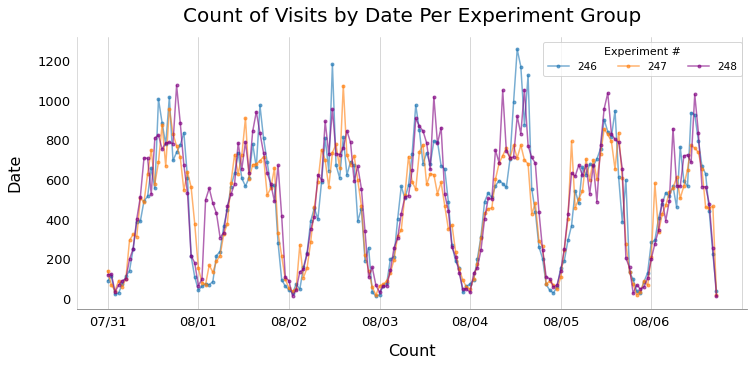

In [340]:
fig, ax = plt.subplots(figsize=(12, 5))
data.groupby(['experiment_id', 'day','hour']).agg({
    'user_id': 'count'
}).query('experiment_id == 246').reset_index(0)['user_id'].plot.line(style='.-',rot=0,alpha=.6)
data.groupby(['experiment_id', 'day','hour']).agg({
    'user_id': 'count'
}).query('experiment_id == 247').reset_index(0)['user_id'].plot.line(style='.-',rot=0,alpha=.6)
data.groupby(['experiment_id', 'day','hour']).agg({
    'user_id': 'count'
}).query('experiment_id == 248').reset_index(0)['user_id'].plot.line(style='.-',rot=0,alpha=.6, color='purple')

ax.set_xticklabels(['/'.join(x.get_text().replace("(","").split(',')[0].split('-')[1:]) for 
                   x in ax.get_xticklabels()])
plt.legend(['246', '247', '248'], fontsize=10.5, ncol=3,title='Experiment #',title_fontsize=11 ,loc='upper right')

custom_graph('x',13,'Count','Date','Count of Visits by Date Per Experiment Group',20,15)


The distribution of event log timestamps are also roughly the same over the three experimental groups.

## AA Test

Here are the criteria for a successful A/A test:
(1)The number of users in different groups doesn't vary by more than 1% -><b>checked in the beginning</b>

(2) For all groups, data on the same event is recorded and sent to analytical systems-> <b>assume that its met (in real life I would dive deeper into this given the potential error seen with the timestamps)</b>
    
(3)None of the key metrics varies by a statistically significant amount—typically by no more than 1% 

(4)Users remain within their groups until the end of the test. If they see different versions of the page during the study, it won't be clear which version influenced their decisions, so the reliability of the results will be compromised -> <b>check (see below)</b>

(5) large enough sample size

In [341]:
data.groupby(['experiment_id']).agg({'user_id':'nunique'}).divide(data['user_id'].nunique()).iloc[:-1]
#1st criteria met

,user_id
experiment_id,
246,0.330055
247,0.333962


Let's check if there is a statistically significant difference in conversion rates between samples 246 and 247.

In [342]:
len(Users_Over580_sessions), len(data)

(17228, 238041)

## Data with no outliers (will be using this frequently in the next cells)

In [343]:
non_outliers = data.query("user_id not in @Useroutlier_index")

In [344]:
# building an array with unique paired date-group values
datesGroups = data[['experiment_id', 'day_hour']].drop_duplicates()

#unique users with total outlier session count (< 538 events)
datesGroups_ = non_outliers[['experiment_id', 'day_hour']].drop_duplicates()

Let's retrieve a dataframe with the cumulative count for the mainscreen and payment screen.

To obtain our cumulative metrics, we'll use the following logic and apply it to the grouped datafame:
<ul>
    <li> <b> Use np.logical_and()</b> method to apply boolean operation to Series objects; helpful in this case given multiple conditions </li>

1. we get the rows of the orders table where the date is less than or equal to the date of the datesGroups element ( because we are working with cumulative data) and the test group is the same as in datesGroup 
2. Filter for either payment screen (or mainscreen)
3. Get the maximum date and maximum experiment id--buffer values-- for the group so that we have the 'date' and 'group' column in the final output
4. 
    <li>We find the number of unique order and user IDs </li>
    <li> calculate the total users per event stage </li>
</ul>

With this code, it's as if we've been calculating the results of our test every day up to the current date and storing them in the rows of the ordersAggregated table. The metric is cumulative, so after some amount of time, we will have enough data to forget about this inaccuracy. 

In [345]:
#dataframe with outliers

#cumulative unique user purchases by date and hour
paymentscreen_Cumulativecount = datesGroups.apply(
    lambda x: data[np.logical_and(data['day_hour'] <= x['day_hour'], data[
        'experiment_id'] == x['experiment_id'])].query(
            "event_name =='PaymentScreenSuccessful'").agg({
                'day_hour': 'max',
                'experiment_id': 'max',
                'user_id': 'nunique'
            }), axis=1)

#cumulative unique users by date and hour
totalCount_Cumulativecount = datesGroups.apply(
    lambda x: data[np.logical_and(data['day_hour'] <= x['day_hour'], data[
        'experiment_id'] == x['experiment_id'])].agg({
                'day_hour': 'max',
                'experiment_id': 'max',
                'user_id': 'nunique'
            }), axis=1)

In [346]:
# damframe without outliers

#cumulative unique user purchases by date and hour
paymentscreen_Cumulativecount_ =datesGroups_.apply(lambda x: non_outliers[
    np.logical_and(non_outliers['day_hour'] <= x['day_hour'], non_outliers[
        'experiment_id'] == x['experiment_id'])].query(
            "event_name =='MainScreenAppear'").agg({
                'day_hour': 'max',
                'experiment_id': 'max',
                'user_id': 'nunique'
            }), axis=1)
#cumulative count of events by date and hour
totalCount_Cumulativecount_ = datesGroups_.apply(lambda x: non_outliers[
    np.logical_and(non_outliers['day_hour'] <= x['day_hour'], non_outliers[
        'experiment_id'] == x['experiment_id'])].agg({
                'day_hour': 'max',
                'experiment_id': 'max',
                'user_id': 'nunique'
            }),axis=1)

In [347]:
#sanity check 
totalCount_Cumulativecount.isnull().sum(), paymentscreen_Cumulativecount.isnull().sum()

(day_hour         0
 experiment_id    0
 user_id          0
 dtype: int64, day_hour         0
 experiment_id    0
 user_id          0
 dtype: int64)

In [348]:
# merging the two tables into one and giving its columns descriptive names - outliers
conversions = pd.merge(paymentscreen_Cumulativecount,
                       totalCount_Cumulativecount,
                       left_on=['day_hour', 'experiment_id'],
                       right_on=['day_hour', 'experiment_id'])
conversions.columns = ['date', 'experiment', 'unique_customers', 'unique_visitors']

# merging the two tables into one and giving its columns descriptive names -non-outliers
conversions_ = pd.merge(paymentscreen_Cumulativecount_,
                        totalCount_Cumulativecount_,
                        left_on=['day_hour', 'experiment_id'],
                        right_on=['day_hour', 'experiment_id'])
conversions_.columns = ['date', 'experiment', 'unique_customers', 'unique_visitors']

In [349]:
paymentscreen_Cumulativecount_,totalCount_Cumulativecount_

(                  day_hour  experiment_id  user_id
 0      2019-07-31 14:00:00            246       15
 1      2019-07-31 14:00:00            247       22
 2      2019-07-31 14:00:00            248       24
 354    2019-07-31 15:00:00            246       34
 357    2019-07-31 15:00:00            248       45
 ...                    ...            ...      ...
 239635 2019-08-07 13:00:00            247     2476
 239637 2019-08-07 13:00:00            246     2445
 240580 2019-08-07 14:00:00            247     2476
 240581 2019-08-07 14:00:00            246     2445
 240584 2019-08-07 14:00:00            248     2486
 
 [507 rows x 3 columns],                   day_hour  experiment_id  user_id
 0      2019-07-31 14:00:00            246       19
 1      2019-07-31 14:00:00            247       24
 2      2019-07-31 14:00:00            248       25
 354    2019-07-31 15:00:00            246       38
 357    2019-07-31 15:00:00            248       46
 ...                    ...           

In [350]:
print(conversions.head())
print()
print(conversions_.head())

                 date  experiment  unique_customers  unique_visitors
0 2019-07-31 14:00:00         246                 1               19
1 2019-07-31 14:00:00         247                 1               24
2 2019-07-31 14:00:00         247                 1               24
3 2019-07-31 14:00:00         248                 3               25
4 2019-07-31 15:00:00         246                 3               38

                 date  experiment  unique_customers  unique_visitors
0 2019-07-31 14:00:00         246                15               19
1 2019-07-31 14:00:00         247                22               24
2 2019-07-31 14:00:00         248                24               25
3 2019-07-31 15:00:00         246                34               38
4 2019-07-31 15:00:00         248                45               46


Conversion rate (x= purchases, y= visits)

In [351]:
#containing outliers
conversions['conversion_rate']=conversions['unique_customers']/conversions['unique_visitors']

#non-outliers
conversions_['conversion_rate']=conversions_['unique_customers']/conversions_['unique_visitors']

In [352]:
conversions['conversion_rate']*100

0       5.263158
1       4.166667
2       4.166667
3      12.000000
4       7.894737
         ...    
502    45.502219
503    45.502219
504    47.755102
505    47.755102
506    45.870088
Name: conversion_rate, Length: 507, dtype: float64

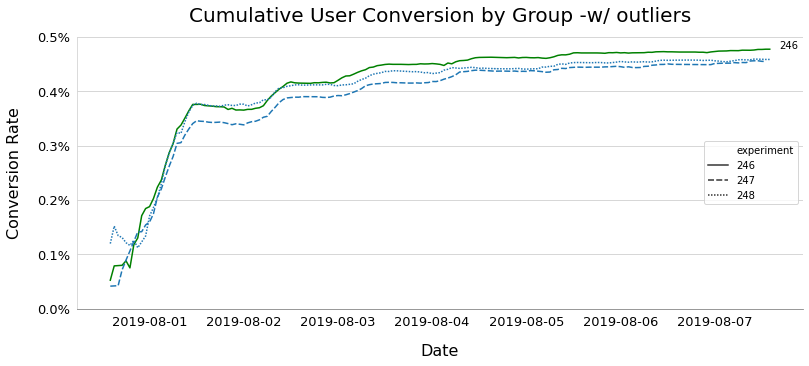

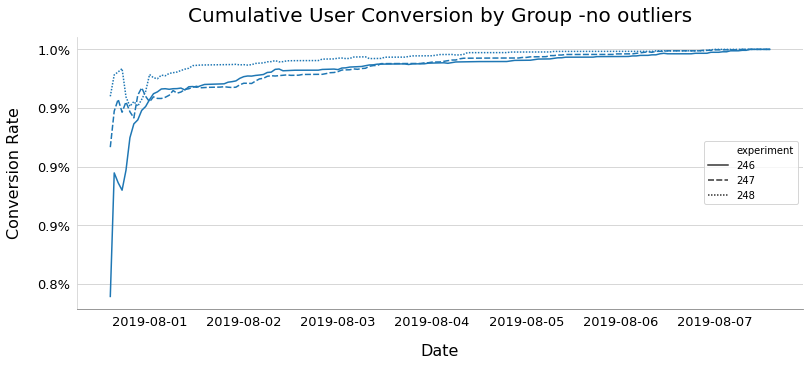

In [357]:
DF_names = ['w/ outliers', 'no outliers']
for df, i in zip([conversions, conversions_], [0, 1]):
    fig, ax = plt.subplots(figsize=(13, 5))

    sns.lineplot(df['date'], df['conversion_rate'], style=df['experiment'])
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=1))
    ax.get_children()[3].set_color('green')
    if i==0:
        ax.set_ylim(0, ax.get_yticks()[-1])
        plt.text(ax.get_children()[3]._x[-1]+.1, ax.get_children()[3]._y[-1],'246')
    
    plt.legend(loc='center right')
    custom_graph('y', 13, 'Date', 'Conversion Rate',
                 'Cumulative User Conversion by Group -' + DF_names[i], 20, 15)

Without outliers, there seems to be a problem: Control group A (246) has a higher conversion rate in comparison to the other control group (247). However, when taking the outliers into account, the difference is no longer apparent. 

Let's take a look at the relative conversion rates amongst the control group.

In [359]:
dates = conversions.query(
    "experiment in [246,247]")['date'].drop_duplicates().append(
        pd.to_datetime(
            pd.Series([str(df['date'].max()), str(df['date'].max())])))

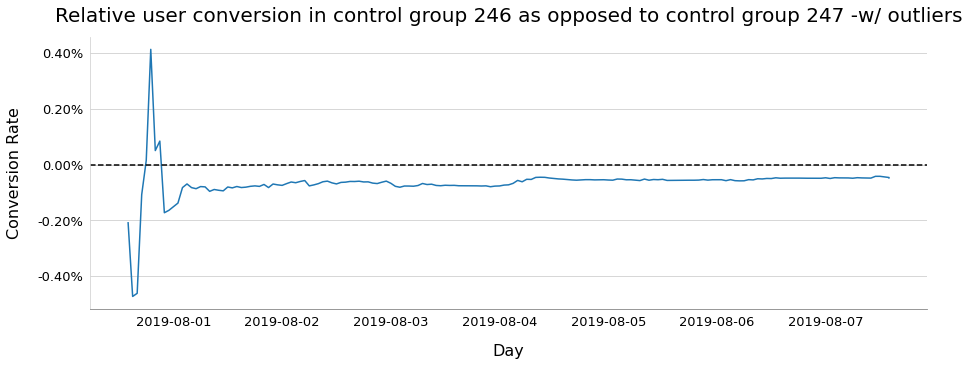

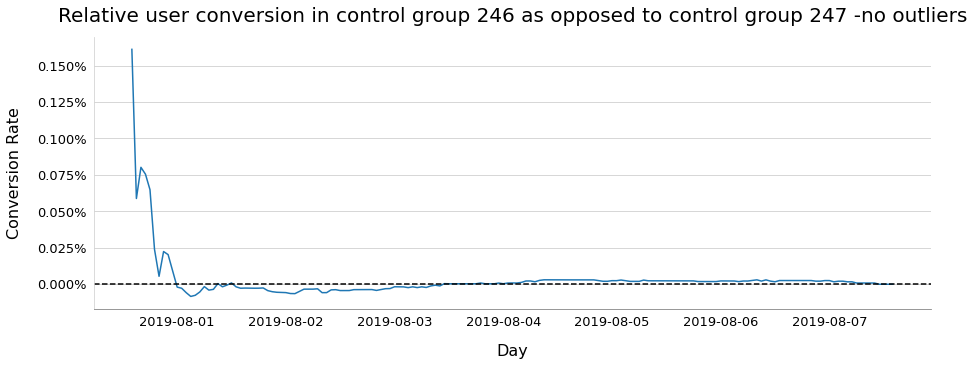

In [360]:
DF_names = ['w/ outliers', 'no outliers']
for df, i in zip([conversions, conversions_], [0, 1]):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(dates,
             (df.query("experiment == 247")['conversion_rate'].reset_index(
                 drop=True) /
              df.query("experiment == 246")['conversion_rate'].reset_index(
                  drop=True)) - 1)
    plt.axhline(y=0, color='black', linestyle='--')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())

    custom_graph(
        'y',
        13,
        'Day',
        'Conversion Rate',
        "Relative user conversion in control group 246 as opposed to control group 247 -"
        + DF_names[i],
        20,
        pad=15)

Conversion rate for A group 246 seem to be stabilizing at a rate higher relative to group 247's conversion rate. When accounting for outliers, the difference absent of which is the expected reuslts given that they stem from the same population. In the following tests, the non-outlier dataframe will be more trustworthy.

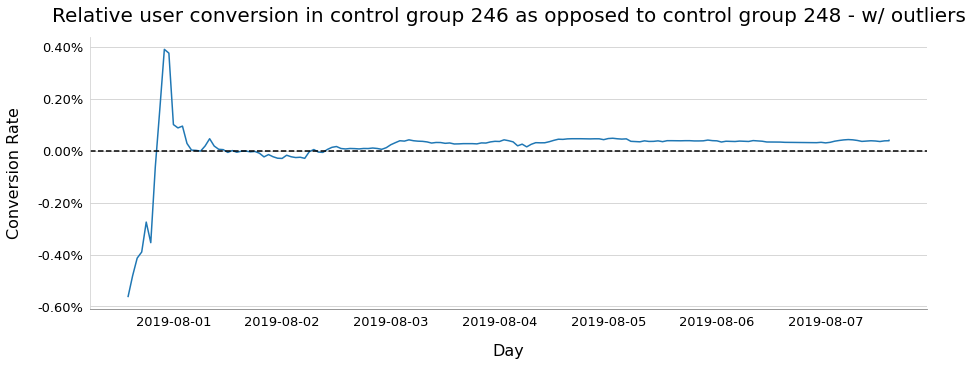

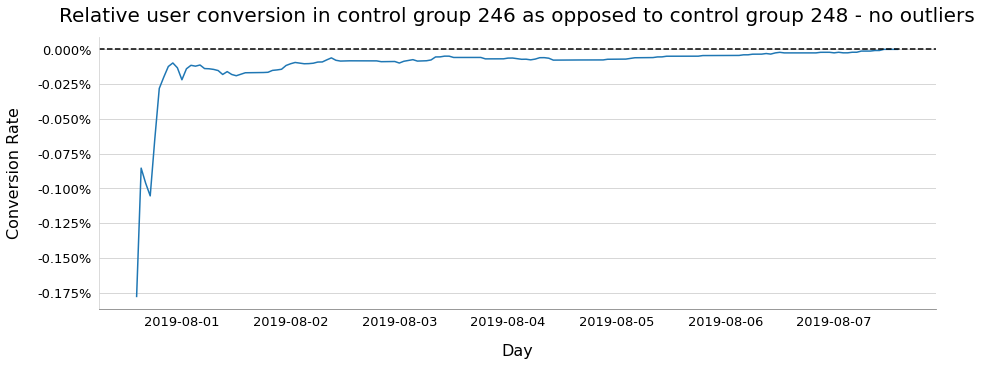

In [361]:
DF_names = ['w/ outliers', 'no outliers']
for df, i in zip([conversions, conversions_], [0, 1]):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(dates,
             (df.query("experiment == 246")['conversion_rate'].reset_index(
                 drop=True) /
              df.query("experiment == 248")['conversion_rate'].reset_index(
                  drop=True)) - 1)
    plt.axhline(y=0, color='black', linestyle='--')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    custom_graph(
        'y',
        13,
        'Day',
        'Conversion Rate',
        "Relative user conversion in control group 246 as opposed to control group 248 - "
        + DF_names[i],
        20,
        pad=15)

Again, a conversion gain is seen in favor of the control group but this may have stemed from the outliers as the non-outliers show no difference. Conversion metrics seem to have stabilized.

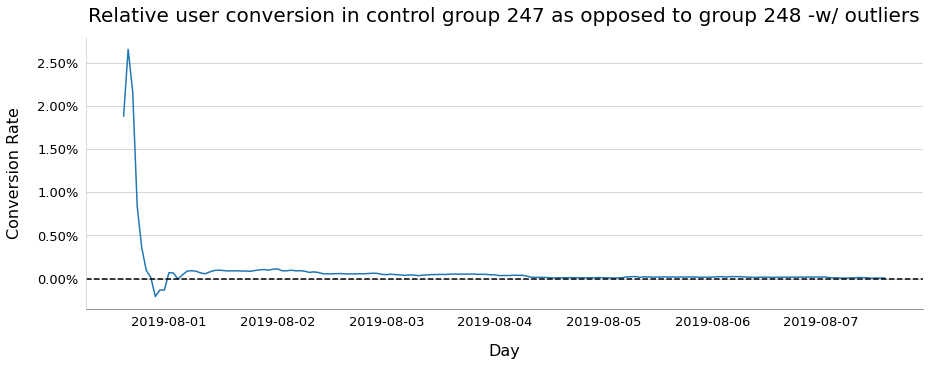

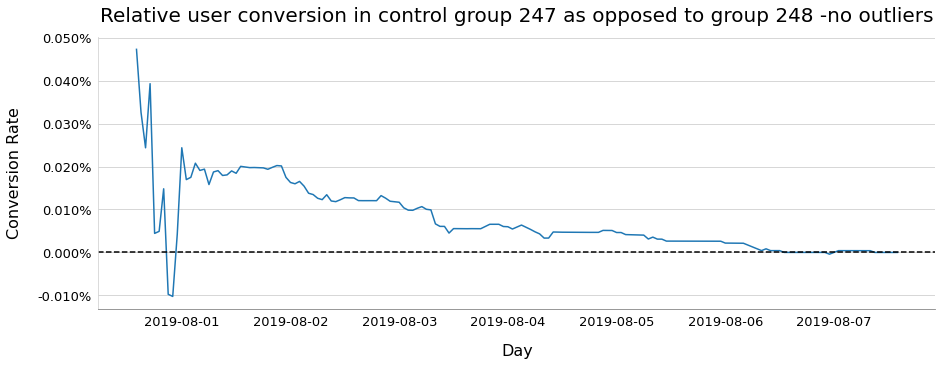

In [362]:
DF_names = ['w/ outliers', 'no outliers']
for df, i in zip([conversions, conversions_], [0, 1]):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.plot(dates,
             (df.query("experiment == 248")['conversion_rate'].reset_index(
                 drop=True) /
              df.query("experiment == 247")['conversion_rate'].reset_index(
                  drop=True)) - 1)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
    plt.axhline(y=0, color='black', linestyle='--')
    custom_graph(
        'y',
        13,
        'Day',
        'Conversion Rate',
        "Relative user conversion in control group 247 as opposed to group 248 -"
        + DF_names[i],
        20,
        pad=15)

No difference is seen between control group 247 and 248 regardless of the outliers being present in the data. 

## Hypothesis Tests


The following will be the hypotheses based on the analysis earlier (pinpoint potential errors in event segmentation, confirm differences amongst the control groups, and get a very rough idea of A/B test results) :

X = font groups (246,247,248)

Y = event (main, offer, cart, and payment)

### CONVERSION RATE: Unique customers / Unique visitors
<ul>
<li>HO: X user conversion rates (&#956;) = X user conversion rate (&#956;)   --w/outliers and no outliers</li>
<li>H1: X user conversion rates (&#956;) != X user conversion rate (&#956;)  -- w.outliers and no outliers</li>
Expect AA to not give any significant results.
    <br/>
    <b>OR</b>

### EVENT PROPORTIONS: EVENT (total Y count) / TOTAL EVENTS (total event count)
<li>HO: XY event proportion (&#956;) = XY event proportion (&#956;)   --w/outliers and no outliers</li>
<li>H1: XY event proportion (&#956;) != XY event proportion (&#956;)  -- w.outliers and no outliers</li>
    <br/></ul>   

To test the hypotheses, we will be using a two proportion Z-test. Since we are looking for equality (not < or >) in proportion means for all the hypotheses, a two-sided test will be used for all of them. Note, the assumptions for the test are met:
<ul>
    <li>sample is greater than 30 <b>(unique users per event > 1,170)</b></li>
    <li>independent samples <b>(A/B tests ->different features and A/A tests -> N/A)</b></li>
    <li>normally distributed given <b>large sample size</b></li>
</ul>

A false positive rate of 10% will be tolerated for this test. 



To test this, we will be using the <b>proportion_ztest</b> methods from the <b>statsmodel</b> library. Here are the parameters used: 

- nobs = total # of unique users (visitors)
- count = # of unique paying users (customers)
- value =  proportion to test against (testing for equality in proportions (conversion rates))
- alternative = alternative hypothesis ('two-sided','smaller','larger')

In [363]:
# If not provided value = 0 and the null is prop[0] = prop[1]
def proportion_ztest(alpha, successes, visits, event_name, test_group_label,
                     first, second, measure = "Conversion Rates"):
    """
    Function that takes in a dataframe, iterates over each of its columns and checks for
    common indicators of missing values (ie. negative values).   

    Args:
         data (pandas.DataFrame): Dataframe to be checked

    Returns:
        list (dict): a list containing (if any) a dictionar[y/ies] of key:value pair in the 
        following format - {column's missing value: % of column's missing value} - sorted in descending order
    """
    
    print(test_group_label, 'Alpha:', alpha)

    stat, pval = proportions_ztest(count=successes,
                                   nobs=visits,
                                   alternative='two-sided')

    if (pval < alpha): 
        print(
            '\t\t\t', event_name, '\n',
            'Rejecting the null hypothesis: there is a significant difference between the proportions.'
        )
    else:
        print(
            '\t\t\t', event_name, '\n',
            "Failed to reject the null hypothesis: there is no reason to consider the proportions different"
        )

    print('P-value:{:.3f}\nZ-value:{:.3f}'.format(pval, stat))
    print('')
    print(first, measure+":", round((successes[0] / visits[0]) * 100,2))
    print(second, measure+":",
          round((successes[1] / visits[1]) * 100, 2))
    
    print( '------------------------------------------------------------------------------')

<h3 style='text-align:center;'>AA test</h3>

Let's group users in the control group in a separate dataframe.

In [364]:
#will be using control group often
ControlGroup = data.query("experiment_id in [246,247]")
ControlGroup_NoOutliers = non_outliers.query("experiment_id in [246,247]")

In [365]:
AA_test= pd.merge(ControlGroup.query("event_name in ['PaymentScreenSuccessful']"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),
         (ControlGroup.groupby('experiment_id').agg({"user_id":"nunique"})),left_index =True, right_index=True)

AA_NoOutliers_test =pd.merge(ControlGroup_NoOutliers.query("event_name in ['PaymentScreenSuccessful']"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),
         (ControlGroup_NoOutliers.groupby('experiment_id').agg({"user_id":"nunique"})),left_index =True, right_index=True)


In [366]:
AA_test.columns = ['unique_customers','unique_visitors']
AA_NoOutliers_test.columns = ['unique_customers','unique_visitors']

In [367]:
AA_test.head, AA_NoOutliers_test

(<bound method NDFrame.head of                unique_customers  unique_visitors
 experiment_id                                   
 246                        1170             2450
 247                        1128             2479>,
                unique_customers  unique_visitors
 experiment_id                                   
 246                        1165             2445
 247                        1125             2476)

In [368]:
alpha = .1
for version in [AA_test, AA_NoOutliers_test]:
    #columns[1] -> unique paying users & columns[0] -> unique visitors
    proportion_ztest(alpha, list(version[version.columns[0]].values),
                 list(version[version.columns[1]].values), '', 'AA ',
                 version.index[0], version.index[1])

AA  Alpha: 0.1
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.113
Z-value:1.585

246 Conversion Rates: 47.76
247 Conversion Rates: 45.5
------------------------------------------------------------------------------
AA  Alpha: 0.1
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.120
Z-value:1.555

246 Conversion Rates: 47.65
247 Conversion Rates: 45.44
------------------------------------------------------------------------------


Both showed no statisically significant result and as such our tests will be considered reliable.

<h3 style='text-align:center;'>Hypothesis Tests Per Event</h3>

Let's test out each event to asses how the control groups were separated. Since we'll be testing the 4 events per group, it's natural that the false positive rate will increase. To correct for this, we'll use the Bonferroni correction: alpha / m (number of comparisons/ hypothesis tests).



### For outliers.
We didn't consider the outlier + raw data experiments together into the Bonferroni correction, because they are 2 different tests, one for the raw data and one for the filtered data-- each requiring a series of experiments (outlined in hypothesis tests). 

In [369]:
alpha = .1
comparisons = 4
bonferroni_alpha = alpha/comparisons


### <u>Where the groups separated properly?</u> 

In [370]:
#w/ outliers
event246 = ControlGroup.query("experiment_id == 246")['event_name'].value_counts()
event247 = ControlGroup.query("experiment_id == 247")['event_name'].value_counts()
event248 = data.query("experiment_id == 248")['event_name'].value_counts()

#total number of events
total246 = len(ControlGroup.query("experiment_id == 246"))
total247 = len(ControlGroup.query("experiment_id == 247"))
total248 = len(data.query("experiment_id == 248"))
    

In [371]:
# w/o outliers
event246_ = ControlGroup_NoOutliers.query("experiment_id == 246")['event_name'].value_counts()
event247_ = ControlGroup_NoOutliers.query("experiment_id == 247")['event_name'].value_counts()
event248_ = non_outliers.query("experiment_id == 248")['event_name'].value_counts()

#total number of events
total246_ = len(ControlGroup_NoOutliers.query("experiment_id == 246"))
total247_ = len(ControlGroup_NoOutliers.query("experiment_id == 247"))
total248_ = len(non_outliers.query("experiment_id == 248"))

In [372]:
events =['MainScreenAppear','OffersScreenAppear','CartScreenAppear','PaymentScreenSuccessful']

### EVENT PROPORTIONS: EVENT COUNT {Group A} / TOTAL EVENTS  {Group A}

## For each event:
- HO: Group 246 event proportion (μ) == Group 247 event proportion (μ) --w/outliers and no outliers
- H1: Group 246 event proportion (μ) != Group 247 event proportion (μ) -- w.outliers and no outliers


In [373]:
for event in events:
    proportion_ztest(
        bonferroni_alpha,  # bonferroni_alpha,
        [event246[event], event247[event]],
        [total246,total247],
        event,
        'AA_Events ',
        '246',
        '247',"Event Proportion")

AA_Events  Alpha: 0.025
			 MainScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:-13.282

246 Event Proportion: 48.26
247 Event Proportion: 51.64
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 OffersScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:-5.228

246 Event Proportion: 18.54
247 Event Proportion: 19.59
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 CartScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:12.686

246 Event Proportion: 18.39
247 Event Proportion: 15.95
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 PaymentScreenSuccessful 
 Rejecting the null hypothesis: there 

All event proportions relative comparisons we're found to be statistically significant (p <.001). (1) Control group 246 had the larger shares in the payment and cart screens (2) Control group 247 had the larger relative share in the mainscreen and offerscreen. This reflects what we saw earlier in the cumulative metrics. Unique users who make a lot of purchases seem to have been placed in 246 at a larger share than in 247

Statistically speaking, visitors to the site from control group 246 and experimental group 248, start of at the same proportions, but after that they differ: a higher proportion from the experimental group get past the first stage (to offers screen) (p < .001) but then after proceed less to the cart (p <.001) and purchase stage (p <.001). 

On the other hand, statistically speaking, those in control group 247 will tend to visit the site more often (p<.001) but then have equal proportions in the next even (offerscreen) indicating a larger dropout in the first stage relative to the experimental group. Thereafter, individuals in the experimental group will more often than not, have a higher event proportion in the cart screen  (p<.001) and payment screen (p<.001).

In [374]:
for event in events:
    proportion_ztest(
        bonferroni_alpha,  # bonferroni_alpha,
        [event246_[event], event247_[event]],
        [total246_,total247_],
        event,
        'AA_Events ',
        '246',
        '247',"Event Proportion")

AA_Events  Alpha: 0.025
			 MainScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:-9.809

246 Event Proportion: 51.57
247 Event Proportion: 54.14
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 OffersScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:-3.872

246 Event Proportion: 19.5
247 Event Proportion: 20.31
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 CartScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:10.029

246 Event Proportion: 16.29
247 Event Proportion: 14.39
------------------------------------------------------------------------------
AA_Events  Alpha: 0.025
			 PaymentScreenSuccessful 
 Rejecting the null hypothesis: there is

When accounting for outliers, the statistically significant results still stand however, as indicated by their z-values, the differences in proportion (dataframe containing outliers) decrease throughout the events. 

This may be of interest to study further as it seems like users were not seperated in each event equally.

----------------------------------------------------

### EVENT PROPORTIONS: EVENT COUNT {Group X} / TOTAL EVENTS  {Group X}


## For each event:
1. 
    - HO: **Group 248** event proportion (μ) == **Group 246** event proportion (μ) --w/outliers and no outliers
    - H1: **Group 248** event proportion (μ) != **Group 246** event proportion (μ) -- w.outliers and no outliers


2. 
    - HO: **Group 248** event proportion (μ) == **Group 247** event proportion (μ) --w/outliers and no outliers
    - H1: **Group 248** event proportion (μ) != **Group 247** event proportion (μ) -- w.outliers and no outliers

In [375]:
alpha = .1
event, groups = 4,2
comparisons = event * groups 
bonferroni_alpha = alpha/(event* comparisons)

In [376]:
for event in events:
    for AA_group, totalAA,label  in zip([event246, event247], [total246, total247],['246','247']):
        proportion_ztest(bonferroni_alpha,
                         [event248[event], AA_group[event]], [total248,totalAA],
                          event, 'AB - Events', 'B: 248',
                         'A:'+label,"Event Proportion")

AB - Events Alpha: 0.003125
			 MainScreenAppear 
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.057
Z-value:1.903

B: 248 Event Proportion: 48.74
A:246 Event Proportion: 48.26
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 MainScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:-11.602

B: 248 Event Proportion: 48.74
A:247 Event Proportion: 51.64
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 OffersScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:3.879

B: 248 Event Proportion: 19.3
A:246 Event Proportion: 18.54
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 OffersScreenAppear 
 Failed to

Statistically speaking, event proportions from control group 247 have a higher mainscreen proportion rate than the experimental group (p<.001), but less in the cart screen (p <.001) and purchase screen (p <.001). 

An inverse result appears between control group 246 and the experimental group. Statistically speaking, visitors to the site from experimental group 248 have a higher mainscreen proportion rate than control group 246 (p<.001), but less in the cart screen (p <.001) and purchase screen (p <.001). 

Let's run this again for the non-outlier data.

In [377]:
for event in events:
    for AA_group, totalAA,label in zip([event246_, event247_], [total246_, total247_],['246','247']):
        proportion_ztest(bonferroni_alpha,
                         [event248_[event], AA_group[event]], [total248_,totalAA],
                          event, 'AB - Events', 'B: 248',
                         'A: '+label,"Event Proportion")

AB - Events Alpha: 0.003125
			 MainScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.000
Z-value:6.462

B: 248 Event Proportion: 53.25
A: 246 Event Proportion: 51.57
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 MainScreenAppear 
 Rejecting the null hypothesis: there is a significant difference between the proportions.
P-value:0.001
Z-value:-3.455

B: 248 Event Proportion: 53.25
A: 247 Event Proportion: 54.14
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 OffersScreenAppear 
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.013
Z-value:2.478

B: 248 Event Proportion: 20.01
A: 246 Event Proportion: 19.5
------------------------------------------------------------------------------
AB - Events Alpha: 0.003125
			 OffersScreenAppear 
 Failed 

When comparing these results against the results seen in the dataframe with outliers, similar results appear as the last one. In particular, we can observe that the event poroportions for the cart and offer screen statistically differ between the two control group and experimental group. Interestingly enough, results favor 248 in relation to control group 247. On the other hand, results favor the control group 246 in relation to the experimental group. 

So, event porpotions

<h3 style='text-align:center;'><u>A1 and B</u> & <u>A2 and B</u> Hypothesis Test -Conversion Rates</h3>

### CONVERSION RATE: Unique customers / Unique visitors

## Per AA group: 
<ul>
    <li>HO: <b>Group 248</b> user conversion rates (&#956;) = <b>AA group</b> user conversion rate (&#956;)   --w/outliers and no outliers</li>
    <li>H1: <b>Group 248</b> user conversion rates (&#956;) != <b>AA group</b> user conversion rate (&#956;)  -- w.outliers and no outliers</li>
    
Checking if font size for experimental group 248 converts more unique users.

In [378]:
bonferroni_alpha = alpha / 2

In [379]:
B_test = pd.merge(data.query("experiment_id == 248 and event_name in ['PaymentScreenSuccessful']"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),
        data.query("experiment_id == 248"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),left_index=True, right_index=True)

In [380]:
B_test_NoOutliers= pd.merge(non_outliers.query("experiment_id == 248 and event_name in ['PaymentScreenSuccessful']"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),
                  non_outliers.query("experiment_id == 248"
             ).groupby('experiment_id').agg({"user_id":"nunique"}),left_index=True, right_index=True)

In [381]:
B_test.columns = ['unique_customers','unique_visitors']
B_test_NoOutliers.columns = ['unique_customers','unique_visitors']

In [382]:
AA_test.iloc[0]

unique_customers    1170
unique_visitors     2450
Name: 246, dtype: int64

In [383]:
proportion_ztest

<function __main__.proportion_ztest(alpha, successes, visits, event_name, test_group_label, first, second, measure='Conversion Rates')>

In [384]:
int(B_test['unique_customers'])

1144

In [385]:

for AA_group in range(2):
    A = AA_test.iloc[AA_group]
    proportion_ztest(bonferroni_alpha,
                    [int(B_test['unique_customers']), A.loc['unique_customers']],
                    [int(B_test['unique_visitors']), A.loc['unique_visitors']],   
                     '', 'AB','248',AA_test.index[AA_group])

AB Alpha: 0.05
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.184
Z-value:-1.328

248 Conversion Rates: 45.87
246 Conversion Rates: 47.76
------------------------------------------------------------------------------
AB Alpha: 0.05
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.795
Z-value:0.260

248 Conversion Rates: 45.87
247 Conversion Rates: 45.5
------------------------------------------------------------------------------


User conversion rates amongst the two groups is not statistically significant.  Let's filter out the outliers and check again.

In [386]:
for AA_group in range(2):
    A = AA_NoOutliers_test.iloc[AA_group]
    proportion_ztest(bonferroni_alpha,
                    [int(B_test_NoOutliers['unique_customers']), A.loc['unique_customers']],
                    [int(B_test_NoOutliers['unique_visitors']), A.loc['unique_visitors']],   
                     '', 'AB','248',AA_NoOutliers_test.index[AA_group])

AB Alpha: 0.05
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.169
Z-value:-1.374

248 Conversion Rates: 45.7
246 Conversion Rates: 47.65
------------------------------------------------------------------------------
AB Alpha: 0.05
			  
 Failed to reject the null hypothesis: there is no reason to consider the proportions different
P-value:0.854
Z-value:0.184

248 Conversion Rates: 45.7
247 Conversion Rates: 45.44
------------------------------------------------------------------------------


When accounting for outliers (and more reliable data for that ammter),the same relations remain.

# Key Takeaways

- On the aggregate level, roughly 40% of unique users who enter the main screen don't proceed to the next stage, offer screen. However, around 81% of users in the offer screen continue to the next stage screen and 94% of them go on to successfully make their purchase. 
-  48% and then 46% of unique users make it to the critical stages in the funnel, cart and payment screen, respectively. 
- Around half of all visits land on the main screen page with < 14% landing on the paymentscreen page. With a 14% conversion rate.
- Users where within .5% of each other - evenly divided across all experimental groups
- Without outliers, there seems to be a problem: Control group A (246) has a higher user conversion rate in comparison to the other control group (247). However, when taking the outliers into account, the difference is no longer apparent across all groups. The cumulative metric graph has shown that user conversion rates have  stabilized.
- Most event proportions we're found to be statistically significant (p <.001) amongst all groups indicating some potential bias in the splitting of users in each event.
- Relative to the experimental group:
        - (1) Control group 246 had the larger shares in the payment and cart screens (2) Control group 247 had the larger relative share in the mainscreen and offerscreen.
- A/B tests showed no statistically significant results (p > .05) amongst the groups regardless of outliers being present or not. 

# Recommendation

1. A further analysis should be done looking at potential errors occurring during the mainscreen and offerscreen stages based on the differing proportions amongst the control groups.
2. Need for improvements in retention at the offer screen as well as potential for improvement in getting customer's from purchasing the items that they have in their cart.
3. Based on the non-significant the A/B test results, stabilizing cumulative charts, the company should: Stop the experiment as the results don't show any improvement in  user conversion rates between the control groups and the experimental group
    - all relevant t-tests regardless of outlier presence: p > .05